In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from dataclasses import dataclass
from pydrake.all import (RandomGenerator, Variables, MathematicalProgram,
                         DecomposeAffineExpression, DecomposeAffineExpressions,
                         HPolyhedron, VPolytope, Formula, FormulaKind, Variable,)
from large_gcs.contact.contact_location import *
from large_gcs.contact.contact_pair_mode import *
from large_gcs.contact.rigid_body import *
from large_gcs.geometry.polyhedron import Polyhedron
from large_gcs.graph.graph import Graph

from collections import Counter

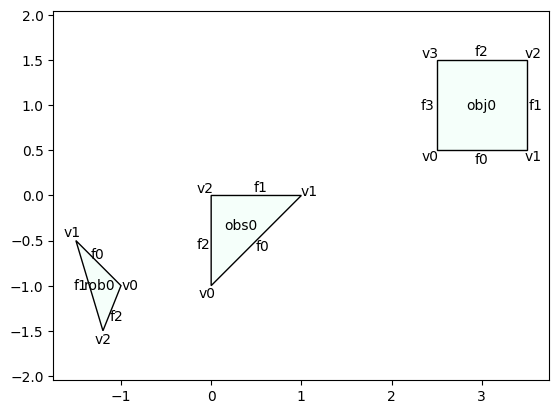

In [2]:
# # 2 items
# obs_vertices = [
#     np.array([[0, 0], [1, 0], [0, -1]])
# ]
# obj_vertices = [
# ]
# rob_vertices = [
#     np.array([[-1,-1],[-1.5,-0.5],[-1.2, -1.5]])
# ]
# 2 movable items
# obs_vertices = [
# ]
# obj_vertices = [
#     np.array([[0, 0], [1, 0], [1, 1], [0,1]]) + np.array([2.5,0.5])
# ]
# rob_vertices = [
#     np.array([[-1,-1],[-1.5,-0.5],[-1.2, -1.5]])
# ]

# 3 items
obs_vertices = [
    np.array([[0, 0], [1, 0], [0, -1]])
]
obj_vertices = [
    np.array([[0, 0], [1, 0], [1, 1], [0,1]]) + np.array([2.5,0.5])
]
rob_vertices = [
    np.array([[-1,-1],[-1.5,-0.5],[-1.2, -1.5]])
]

# # 4 items
# obs_vertices = [
#     np.array([[0, 0], [1, 0], [0, -1]])
# ]
# obj_vertices = [
#     np.array([[0, 0], [1, 0], [1, -0.5]]) + np.array([1.5, 0]),
#     np.array([[0, 0], [1, 0], [1, 1], [0,1]]) + np.array([2.5,0.5])
# ]
# rob_vertices = [
#     np.array([[-1,-1],[-1.5,-0.5],[-1.2, -1.5]])
# ]
obs = []
objs = []
robs = []
for i in range(len(obs_vertices)):
    obs.append(RigidBody(name=f"obs{i}", geometry=Polyhedron.from_vertices(obs_vertices[i]),
                mobility_type=MobilityType.STATIC))
for i in range(len(obj_vertices)):
    objs.append(RigidBody(name=f"obj{i}", geometry=Polyhedron.from_vertices(obj_vertices[i]),
                mobility_type=MobilityType.ACTUATED))
for i in range(len(rob_vertices)):
    robs.append(RigidBody(name=f"rob{i}", geometry=Polyhedron.from_vertices(rob_vertices[i]),
                mobility_type=MobilityType.ACTUATED))
all_rigid_bodies = obs + objs + robs
for rigid_body in all_rigid_bodies:
    rigid_body.plot()
# plt.s
# temp_sets = [rigid_body.geometry for rigid_body in all_rigid_bodies]
# temp_names = [rigid_body.name for rigid_body in all_rigid_bodies]
# G = Graph()
# G.add_vertices_from_sets(temp_sets,names=temp_names)
# G.plot_sets()
# G.plot_set_labels()

def generate_contact_sets(static_obstacles: List[RigidBody], unactuated_objects: List[RigidBody], actuated_robots: List[RigidBody]):
    """Generates all possible contact sets given a set of static obstacles, unactuated objects, and actuated robots."""
    body_dict = {body.name: body for body in static_obstacles + unactuated_objects + actuated_robots}
    obs_names = [body.name for body in static_obstacles]
    obj_names = [body.name for body in unactuated_objects]
    rob_names = [body.name for body in actuated_robots]

    # movable = unactuated_objects + actuated_robots
    # static_movable_pairs = list(itertools.product(static_obstacles, movable))
    # movable_pairs = list(itertools.combinations(movable, 2))
    # rigid_body_pairs = static_movable_pairs + movable_pairs
    movable = obj_names + rob_names
    static_movable_pairs = list(itertools.product(obs_names, movable))
    movable_pairs = list(itertools.combinations(movable, 2))
    rigid_body_pairs = static_movable_pairs + movable_pairs

    body_pair_to_modes = {
        (body1, body2): generate_contact_pair_modes(body_dict[body1], body_dict[body2]) for body1, body2 in rigid_body_pairs
    }
    body_pair_to_mode_names = {
        (body1, body2): [mode.id for mode in modes] for (body1, body2), modes in body_pair_to_modes.items()
    }
    mode_ids_to_mode = {
        mode.id: mode 
            for modes in body_pair_to_modes.values()
                for mode in modes
    }
    # Each set is the cartesian product of the modes for each pair
    set_ids = list(itertools.product(*body_pair_to_mode_names.values()))
    
    return set_ids, mode_ids_to_mode

set_ids, mode_ids_to_mode = generate_contact_sets(obs, objs, robs)
# contact_pair_modes = generate_contact_pair_modes(obs, obj)
# for contact_pair_mode in contact_pair_modes:
#     contact_pair_mode.plot()

In [6]:
class ContactSet(ConvexSet):
    def __init__(self, contact_pair_modes: List[ContactPairMode], all_variables: List[Variables]):
        self.contact_pair_modes = contact_pair_modes
        self.constraint_formulas = [constraint.item()
                                    for mode in contact_pair_modes
                                        for constraint in mode.constraint_formulas]
        self._polyhedron = self._construct_polyhedron_from_constraints(self.constraint_formulas, all_variables)


    def _construct_polyhedron_from_constraints(self, constraints: List[Formula], all_variables: List[Variables]):
        """
        Construct a polyhedron from a list of constraint formulas.
        Args:
            constraints: array of constraint formulas.
            variables: array of variables.
        """

        # In case the variables were multi-dimensional lists
        variables = np.concatenate([v.flatten() for v in all_variables])

        expressions = []
        for formula in constraints:
            kind = formula.get_kind()
            lhs, rhs = formula.Unapply()[1]
            if kind == FormulaKind.Eq:
                # Eq constraint ax = b is
                # implemented as ax ≤ b, -ax <= -b
                expressions.append(lhs - rhs)
                expressions.append(rhs - lhs)
            elif kind == FormulaKind.Geq:
                # lhs >= rhs
                # ==> rhs - lhs ≤ 0
                expressions.append(rhs - lhs)
            elif kind == FormulaKind.Leq:
                # lhs ≤ rhs
                # ==> lhs - rhs ≤ 0
                expressions.append(lhs - rhs)
            else:
                raise NotImplementedError("Type of constraint formula not implemented")

        # We now have expr ≤ 0 for all expressions
        # ==> we get Ax - b ≤ 0
        A, b_neg = DecomposeAffineExpressions(expressions, variables)

        # Polyhedrons are of the form: Ax <= b
        b = -b_neg
        polyhedron = HPolyhedron(A, b)

        return polyhedron


    @property
    def id(self):
        return tuple([mode.id for mode in self.contact_pair_modes])
    
    @property
    def dim(self):
        return self.set.A().shape[1]
    
    @property
    def set(self):
        return self._polyhedron
    
    @property
    def center(self):
        raise NotImplementedError
    
# print(set_ids.shape)
# print(set_ids[0:50])

In [7]:
all_variables = [body.vars_pos for body in  objs+robs]

all_contact_sets = [ContactSet([mode_ids_to_mode[mode_id] for mode_id in set_id], all_variables) for set_id in set_ids]
non_empty_sets = [contact_set for contact_set in all_contact_sets if not contact_set.set.IsEmpty()]
contact_sets = {
    contact_set.id: contact_set for contact_set in non_empty_sets
}

print(len(non_empty_sets))

# num_empty_sets = 0
# for set_id, contact_set in contact_sets.items():
#     if contact_set.set.IsEmpty():
#         num_empty_sets += 1
# print(f"total num sets: {len(contact_sets)}, num empty sets: {num_empty_sets}")

# test_set = contact_set([mode_ids_to_mode[mode_id] for mode_id in set_ids[0]], all_variables)

Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f0-rob0_v1', 'IC:obj0_f0-rob0_v1')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f0-rob0_v1', 'IC:obj0_f1-rob0_v1')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f0-rob0_v1', 'IC:obj0_f2-rob0_v2')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f0-rob0_v1', 'IC:obj0_f3-rob0_v0')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f0-rob0_v1', 'IC:obj0_v0-rob0_f0')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f0-rob0_v1', 'IC:obj0_v2-rob0_f1')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f0-rob0_v1', 'IC:obj0_v3-rob0_f2')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f0-rob0_v1', 'NC:obj0_f2-rob0_v2')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f1-rob0_v2', 'IC:obj0_f0-rob0_v1')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f1-rob0_v2', 'IC:obj0_f1-rob0_v1')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f1-rob0_v2', 'IC:obj0_f2-rob0_v2')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f1-rob0_v2', 'IC:obj0_v0-rob0_f0')
Empty set: ('IC:obs0_f1-obj0_f0', 'IC:obs0_f1-rob0_v2', 'IC:obj0

In [10]:
import random


[sample.id for sample in random.sample(non_empty_sets, 5)]

[('NC:obs0_f1-obj0_f0', 'NC:obs0_f2-rob0_v0', 'IC:obj0_f0-rob0_v1'),
 ('NC:obs0_f0-obj0_v3', 'NC:obs0_f2-rob0_v0', 'NC:obj0_f1-rob0_v1'),
 ('IC:obs0_f0-obj0_v3', 'NC:obs0_f1-rob0_v2', 'NC:obj0_f3-rob0_v0'),
 ('IC:obs0_v1-obj0_f3', 'IC:obs0_f1-rob0_v2', 'IC:obj0_f3-rob0_v0'),
 ('NC:obs0_f0-obj0_v3', 'IC:obs0_f1-rob0_v2', 'NC:obj0_f2-rob0_v2')]